In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
// Disabled iPython Notebook Autoscrolling
// https://stackoverflow.com/questions/36757301/disable-ipython-notebook-autoscrolling

<IPython.core.display.Javascript object>

In [2]:
# Importing Relevant Modules
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', 100)
import warnings
import json
import glob

from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

## 1. Global Variables

In [3]:
# Input directory from where data will be read
cleaned_dataset_dir ="./Dataset"

# Output directory where figures and results will be stored
result_dir = "./Results"

# Following dictionary variables will store data indexed by app ID
app_names = {}                 # value: human readable app name
dataset = {}                 # value: input dataset for each app ID
roc_score_hist = {}          # value: AUC-ROC plot for each app
auc_score_app = {}           # value: AUC score for each app ID

# Numpy Random seed for reproducibility
# call np.random.seed(random_seed) before every np.random invocations
random_seed = 11

In [4]:
# DEFINE FEATURES
# Features to be included in the study
features = ['Rating',
            'NumBodyChars','NumTitleChars',
            'BodySentiment','TitleSentiment',
            'PositiveWordsBody','NegativeWordsBody','PositiveWordsTitle','NegativeWordsTitle',
            'PD_body','FR_body','IS_body','IG_body',
            'PD_title','FR_title','IS_title','IG_title',
            'ReadabilityBody','MisspelledWordsBody','ModalVerbsBody','UniqueWordsBody',
            'FirstCapBody','AllCapBody',
            'ReadabilityTitle','MisspelledWordsTitle','ModalVerbsTitle', 'UniqueWordsTitle', 
            'FirstCapTitle','AllCapTitle',
            'ContainsDigit',
            'VoteHelpful','VoteTotal',
            'TimeAfterRelease',
            'Is_Monday','Is_Tuesday','Is_Wednesday','Is_Thursday','Is_Friday','Is_Saturday','Is_Sunday',
            'Is_Night','Is_Morning','Is_Afternoon','Is_Evening',
            'IsWeekend']

# Group of features used for feature importance analysis
    
# group_1 = rating,length,sentiment,intention,style,vote, and time.
group_list = ['Rating','Length','Sentiment','Intention','Style','Vote','Time']
groups = [
     ['Rating'], 
     ['NumBodyChars','NumTitleChars'],  
     ['BodySentiment','TitleSentiment','PositiveWordsBody','NegativeWordsBody','PositiveWordsTitle','NegativeWordsTitle'], 
     ['PD_body','FR_body','IS_body','IG_body','PD_title','FR_title','IS_title','IG_title'],
     ['ReadabilityBody','MisspelledWordsBody','ModalVerbsBody','UniqueWordsBody',
     'FirstCapBody','AllCapBody',
     'ReadabilityTitle','MisspelledWordsTitle','ModalVerbsTitle', 'UniqueWordsTitle', 
     'FirstCapTitle','AllCapTitle',
     'ContainsDigit'],
     ['VoteHelpful','VoteTotal'],
     ['TimeAfterRelease',
       'Is_Monday','Is_Tuesday','Is_Wednesday','Is_Thursday','Is_Friday','Is_Saturday','Is_Sunday',
       'Is_Night','Is_Morning','Is_Afternoon','Is_Evening',
       'IsWeekend']
     ]

# group_2 = text vs non-text
groups_list_2 = ["Non-textual","Textual"]
groups_2 = [
            ['Rating','TimeAfterRelease','Is_Monday','Is_Tuesday','Is_Wednesday',
                              'Is_Thursday','Is_Friday','Is_Saturday','Is_Sunday','Is_Night',
                              'Is_Morning','Is_Afternoon','Is_Evening','IsWeekend',
                              'VoteHelpful','VoteTotal'],
             ['NumBodyChars','NumTitleChars',
                              'BodySentiment','TitleSentiment','PositiveWordsBody','NegativeWordsBody',
                              'PositiveWordsTitle','NegativeWordsTitle',
                              'PD_body','FR_body','IS_body','IG_body',
                              'PD_title','FR_title','IS_title','IG_title',
                              'ReadabilityBody','MisspelledWordsBody','ModalVerbsBody',
                              'UniqueWordsBody','FirstCapBody','AllCapBody',
                              'ReadabilityTitle','MisspelledWordsTitle','ModalVerbsTitle', 
                              'UniqueWordsTitle', 'FirstCapTitle','AllCapTitle',
                              'ContainsDigit']
           ]

## 2. Read Dataset

In [5]:
# Populate dataset and appname dictionaries by reading input data\

for filename in glob.glob(os.path.join(cleaned_dataset_dir, '*.csv')):
    df = pd.read_csv(filename,dtype={"is_response":np.int64},lineterminator='\n')
    app_name = df["appName"].iloc[0]
    appid = df["appId"].iloc[0]
    app_names[appid] = re.sub('[^a-zA-Z]+', '',app_name.split(" ")[0])
    print("Reading: id = {} \t name = {}".format(appid,app_names[appid]))
    dataset[appid] = df
print("Done!")

Reading: id = 284847138 	 name = Bank
Reading: id = 881599819 	 name = StockX
Reading: id = 985746746 	 name = Discord
Reading: id = 1241229134 	 name = Reflectly
Reading: id = 336698281 	 name = Realtorcom
Reading: id = 283646709 	 name = PayPal
Reading: id = 896130944 	 name = Mercari
Reading: id = 281940292 	 name = WeatherBug
Done!


## 3. Machine Learning Pipeline

### 3.1 Remove correlated features from train and test dataset

In [6]:
def remove_correlation(train,test,corr_matrix, threshold, features):
    """
    Removes highly correlated features and returns filtered input features dataset
    
    Parameters
    ------------
    train :        dataframe contains train data
    test :         dataframe contains test data
    corr_matrix :  dataframe contains correlation matrix, computed on train dataset
    threshold :    correlation above this integral value will be deemed as high
    features :     list of features to be considered for correlation analysis 
    
    Returns
    --------
    x_train :      dataframe contains filtered input features for training
    x_test:        dataframe contains filtered input features for testing
    """
    
    # Calculate Mutual Information (MI)
    inf_gain = dict(zip(features,mutual_info_classif(train[features], train['is_response'], 
                                                     discrete_features='auto',random_state=random_seed)))

    # Select columns with correlations above threshold and drop one with lower information gain
    print("=="*10+"FINDING CORRELATED FEATURES"+"=="*10)
    correlated_columns = []
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)) #upper triangle of correlation
    features = upper.columns.values.tolist()
    for row in features:
        for col in features:
            if upper.loc[row,col]>threshold and row!=col:
                correlated_columns.append([row,col])
                print("Correlated features:", row,",",col,"is", upper.loc[row,col])
                print("Mutual Information for", row, "is",inf_gain[row], "and for", col,"is",inf_gain[col])
                print("--"*10)
    to_drop = []
    for entry in correlated_columns:
        if entry[0] not in to_drop and entry[1] not in to_drop:
            to_drop.append(entry[0]) if inf_gain[entry[0]]<inf_gain[entry[1]] else to_drop.append(entry[1])
    
    print('There are %d columns to remove.' % (len(to_drop)),"which are",to_drop)
    to_drop += list(set(list(train.columns.values))-set(features))

    x_train = train.drop(columns = to_drop)
    x_test = test.drop(columns = to_drop)

    feature_list = list(x_train.columns)
    print("Selected features:")
    print(feature_list)
    print("Total number of features selected: ",len(feature_list))
    
    return x_train, x_test

In [7]:
def data_preparation(data, app_name, threshold):
    """
    Split data into train & test, and filter out highly correlated features
    
    Parameters
    ------------
    data :          dataframe storing app_name data
    app_name :      string contains human readable app name
    threshold :     correlation above this integral value will be deemed as high
    
    Returns
    --------
    train :         dataframe contains train data
    x_train :       dataframe contains filtered input features for training
    y_train :       numpy array of training labels
    test :          dataframe contains test data
    x_test :        dataframe contains filtered input features for testing
    y_test :        numpy array of testing labels
    """
        
    # Split the data into training and testing sets
    train, test = train_test_split(data, stratify=data["is_response"], test_size = 0.2, random_state = random_seed, shuffle=True)
    y_train = np.array(train['is_response'])
    y_test = np.array(test['is_response'])
    
    print("Total features: "+str(len(features)))
    print('Training Shape:', train[features].shape)
    print('Testing Shape:', test[features].shape)

    # Measure correlation between variables (Spearman)
    corr_matrix = train[features].corr(method="spearman").abs()

    # Plot and save correlation matrix
    f = plt.figure(figsize=(19, 15))
    plt.matshow(corr_matrix, fignum=f.number,cmap='Greens')
    plt.xticks(range(corr_matrix.shape[1]), corr_matrix.columns, fontsize=14, rotation=90)
    plt.yticks(range(corr_matrix.shape[1]), corr_matrix.columns, fontsize=14)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=20)
    plt.savefig(result_dir+"/correlation_"+app_name+".png",bbox_inches='tight')
    plt.close(f)
    
    # Remove correlated features
    x_train, x_test = remove_correlation(train,test,corr_matrix, threshold, features)
    
    return train, x_train, y_train, test, x_test, y_test

### 3.2 Hyperparameter tuning for Random Forest Model

In [8]:
def rf_model(train, x_train, y_train, test, x_test, y_test, num_iterations, num_folds):
    """
    Training RF model using RandomizedSearchCV and evaluate performance of best model obtained
    
    Parameters
    ------------
    train :         dataframe contains train data
    x_train :       dataframe contains filtered input features for training
    y_train :       numpy array of training labels
    test :          dataframe contains test data
    x_test :        dataframe contains filtered input features for testing
    y_test :        numpy array of testing labels
    num_iterations: no. of parameter settings that are sampled from hyperparameter search space
    num_folds:      no. of cross validation folds used
    
    Returns
    --------
    rf :            trained random forest model
    train :         dataframe contains train data (added predictions column)
    test :          dataframe contains test data (added predictions column)
    """
    
    # Hyperparameter search space 
    print("=="*30)
    print("Hyperparameter search space:")
    feature_list = list(x_train.columns)
    n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
    total_features = len(feature_list)
    max_features = [int(x) for x in np.linspace(start = np.sqrt(total_features), 
                                                stop = total_features, num = int(np.sqrt(total_features)))]
    max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
    min_samples_split = [0.01, 0.03, 0.05]
    min_samples_leaf = [1, 3, 5]
    bootstrap = [True]
    random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
    print(random_grid)
    grid_space = len(n_estimators)*len(max_features)*len(max_depth)*len(min_samples_split)*len(min_samples_leaf)
    print("Size: "+str(grid_space))
    print("--"*30)
    
    # Use RandomizedSearchCV to find best model parameters through cross validation
    rf_base = RandomForestClassifier(random_state = random_seed, class_weight="balanced",n_jobs=-1)
    rf = RandomizedSearchCV(estimator = rf_base, param_distributions = random_grid, 
                            n_iter = num_iterations, cv = num_folds, verbose=1, random_state=random_seed)
    rf.fit(np.array(x_train), y_train.reshape(-1))
    print("Best CV parameters obtained are: ",rf.best_params_)
    
    # Calculate AUC scores
    print("=="*10+"Calculate AUC scores"+"=="*10)
    test["predictions"] = rf.predict_proba(np.array(x_test))[:,1]
    train["predictions"] = rf.predict_proba(np.array(x_train))[:,1]
    test["prediction_class"] = rf.predict(np.array(x_test))
    train["prediction_class"] = rf.predict(np.array(x_train)) 
    print("Training AUC score:", roc_auc_score(y_train, train["predictions"]))
    print("Testing AUC score:", roc_auc_score(y_test, test["predictions"]))
    
    return rf, train, test
    

### 3.3 Feature Importance

In [9]:
def permutation_importances(rf, X_valid, y_valid, metric, ftr):
    """
    Compute individual feature importance for Random Forest Model over passed X and y. 
    It assigns importance to a feature by calculating the drop in model performance recorded by random permutation of that feature
    
    Parameters
    ------------
    rf :            trained random forest model
    X_valid :       dataframe contains input features to rf
    y_valid :       numpy array of true labels
    metric :        metric used to evaluate model performance
    ftr :           list of input features
    
    Returns
    --------
    imp :            numpy array of feature importances
    """
    baseline = metric(y_valid,rf.predict_proba(np.array(X_valid))[:,1])
    imp = []
    for col in ftr:
        save = X_valid[col].copy()
        np.random.seed(random_seed)
        X_valid[col] = np.random.permutation(X_valid[col])
        m = metric(y_valid,rf.predict_proba(np.array(X_valid))[:,1])
        X_valid[col] = save
        imp.append(baseline - m)

    feature_list = list(X_valid.columns.values)    
    feature_importances = [(feature, round(importance, 3)) for feature, importance in zip(feature_list, imp)]
    
    # sort the feature importances by most important first and print
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances[:15]]
    return np.array(imp)

In [10]:
def permutation_importances_groups(rf, X_valid, y_valid, grp, grp_list, metric):
    """
    Compute group feature importance for Random Forest Model over passed X and y. 
    It assigns importance to a feature-group by calculating the drop in model performance recorded 
    by random permutation of that feature-group
    
    Parameters
    ------------
    rf :            trained random forest model
    X_valid :       dataframe contains input features to rf
    y_valid :       numpy array of true labels
    grp_list:       list comprising feature-groups for which importance will be calculated
    grp:            list of list of features that comprise each feature-group
    metric :        metric used to evaluate model performance
    
    Returns
    --------
    imp :            numpy array of feature-group importances
    """
    baseline = metric(y_valid,rf.predict_proba(np.array(X_valid))[:,1])
    imp = []
    for group in grp:
        save = {}
        for col in group:
            if col in X_valid.columns:
                save[col] = X_valid[col].copy()
        for col in group:
            if col in X_valid.columns:
                np.random.seed(random_seed)
                X_valid[col] = np.random.permutation(X_valid[col])
        m = metric(y_valid,rf.predict_proba(np.array(X_valid))[:,1])
        for col in group:
            if col in X_valid.columns:
                X_valid[col] = save[col]
        imp.append(baseline - m)
    group_importances = [(feature, round(importance, 3)) for feature, importance in zip(grp_list, imp)]
    
    # sort the feature importances by most important first and print
    group_importances = sorted(group_importances, key = lambda x: x[1], reverse = True)
    [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in group_importances]  
    return np.array(imp)

### 3.4 Plot Results

In [11]:
def plot_auc_roc(test,app_name):
    """
    Plot AUC-ROC curve to show model performance over test data. 
    Also updates global variables roc_score_hist and auc_score_app.
    
    Parameters
    ------------
    test :          dataframe contains test data
    app_name :      string contains human readable app name
    
    Returns
    --------
    """
    
    y_test = test['is_response']
    y_pred = test["predictions"]
    
    # baseline models
    base_majority_fpr, base_majority_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
    np.random.seed(random_seed)
    base_random_fpr, base_random_tpr, _ = roc_curve(y_test,np.random.randint(2, size=len(y_test)))
    
    # random forest model results
    fpr, tpr, _ = roc_curve(y_test,  y_pred)
    roc_app = {}
    roc_app["fpr"] = fpr
    roc_app["tpr"] = tpr
    
    
    # find the AUC value
    auc_model = roc_auc_score(y_test, y_pred)
    auc_base_majority = roc_auc_score(y_test,[1 for _ in range(len(y_test))])
    np.random.seed(random_seed)
    auc_base_random = roc_auc_score(y_test,np.random.randint(2, size=len(y_test)))
    
    # update global variables
    auc_score_app[app_name] = auc_model
    roc_score_hist[app_name] = roc_app
    
    # plot graphs
    plt.figure(figsize = (10, 6))
    plt.rcParams['font.size'] = 12
    plt.plot(fpr,tpr,label="Random Forest, AUC="+str(round(auc_model, 2)))
    plt.plot(base_majority_fpr,base_majority_tpr,'b',label="MajorityClass, AUC="+str(round(auc_base_majority,2)))
    plt.plot(base_random_fpr,base_random_tpr,'r',label="Random, AUC="+str(round(auc_base_random,2)))
    plt.legend(loc=4,fontsize = 16)
    plt.xlabel('False Positive Rate',fontsize = 16,labelpad=10)
    plt.ylabel('True Positive Rate',fontsize = 16,labelpad=10)
    plt.title('ROC Curves',fontsize = 16)
    plt.savefig(result_dir+"/"+ app_name + "_auc_baseline_curve.png",bbox_inches='tight')
    plt.show() 

### 4. Application of ML Pipeline

In [12]:
def build_model(data,app_name):
    """
    Apply ML pipeline to the passed data and save output results 
    
    Parameters
    ----------------------------
    data:        DataFrame containing reviews for selected app
    app_name:    name of the app to be analyzed
    
    Returns
    --------
    """
    
    print("Building Models for ", app_name)
    
    # Remove correlated features from train and test dataset
    threshold = 0.7
    train, x_train, y_train, test, x_test, y_test = data_preparation(data, app_name, threshold)
    
    # Hyperparameters tuning for RF model
    num_iterations = 100
    num_crossvalid_folds = 4
    rf, train, test = rf_model(train, x_train, y_train, test, x_test, y_test, num_iterations, num_crossvalid_folds)
    
    # Feature Importance Analysis
    print("=="*10+"Feature Importance Analysis"+"=="*10)
    print("Individual Feature Importance----")
    ind_imp_train = permutation_importances(rf, x_train, pd.DataFrame(y_train), roc_auc_score,ftr=list(x_train.columns.values))
    print("--"*30)
    print("Groups of Features Importance")
    group_imp_train = permutation_importances_groups(rf, x_train, pd.DataFrame(y_train),grp=groups,grp_list=group_list,metric=roc_auc_score)
    print(".."*10)
    group_imp_train_2 = permutation_importances_groups(rf, x_train, pd.DataFrame(y_train),grp=groups_2,grp_list=groups_list_2,metric=roc_auc_score)
    print("--"*20)
    
    # Plot Results
    plot_auc_roc(test,app_name)
    
    # Save results to csv
    test.to_csv(result_dir+"/"+app_name.split()[0]+"_test.csv")
    train.to_csv(result_dir+"/"+app_name.split()[0]+"_train.csv")

Building Models for  Mercari
Total features: 45
Training Shape: (7028, 45)
Testing Shape: (1758, 45)
====================FINDING CORRELATED FEATURES====================
Correlated features: NumBodyChars , UniqueWordsBody is 0.8740729749469939
Mutual Information for NumBodyChars is 0.007900869089645601 and for UniqueWordsBody is 0.004819761459215144
--------------------
Correlated features: NumTitleChars , UniqueWordsTitle is 0.874521258041344
Mutual Information for NumTitleChars is 0.0020349973704036906 and for UniqueWordsTitle is 0.0
--------------------
Correlated features: VoteHelpful , VoteTotal is 0.9395466029415949
Mutual Information for VoteHelpful is 0.005216541332351721 and for VoteTotal is 0.0
--------------------
Correlated features: Is_Saturday , IsWeekend is 0.7038745619076547
Mutual Information for Is_Saturday is 0.0030657601120209765 and for IsWeekend is 0.0012491117168327293
--------------------
There are 4 columns to remove. which are ['UniqueWordsBody', 'UniqueWordsTi

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  9.0min finished


Best CV parameters obtained are:  {'n_estimators': 500, 'min_samples_split': 0.01, 'min_samples_leaf': 1, 'max_features': 34, 'max_depth': 20, 'bootstrap': True}
====================Calculate AUC scores====================
Training AUC score: 0.9129370034583432
Testing AUC score: 0.6978793899800267
====================Feature Importance Analysis====================
Individual Feature Importance----
Variable: Rating               Importance: 0.183
Variable: TimeAfterRelease     Importance: 0.16
Variable: NumBodyChars         Importance: 0.079
Variable: PositiveWordsBody    Importance: 0.052
Variable: NumTitleChars        Importance: 0.038
Variable: NegativeWordsBody    Importance: 0.033
Variable: PositiveWordsTitle   Importance: 0.029
Variable: MisspelledWordsBody  Importance: 0.022
Variable: ModalVerbsBody       Importance: 0.022
Variable: ReadabilityBody      Importance: 0.018
Variable: ReadabilityTitle     Importance: 0.011
Variable: MisspelledWordsTitle Importance: 0.01
Variable: Vo

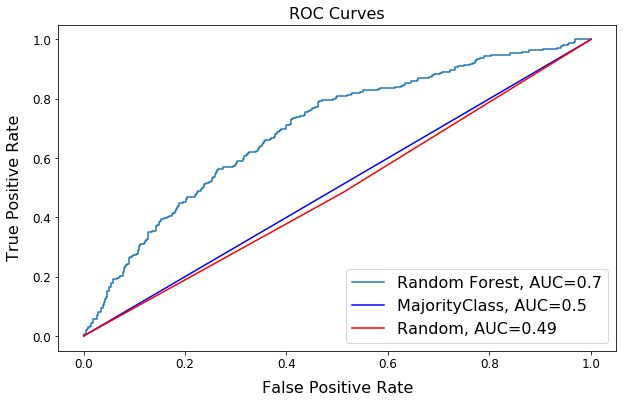

In [13]:
#896130944 Mercari:
build_model(dataset[896130944],app_names[896130944])

Building Models for  Bank
Total features: 45
Training Shape: (11607, 45)
Testing Shape: (2902, 45)
====================FINDING CORRELATED FEATURES====================
Correlated features: NumBodyChars , UniqueWordsBody is 0.7765641887932077
Mutual Information for NumBodyChars is 0.029818833140904166 and for UniqueWordsBody is 0.01547421973141816
--------------------
Correlated features: NumTitleChars , UniqueWordsTitle is 0.8540479128748825
Mutual Information for NumTitleChars is 0.01599477392352 and for UniqueWordsTitle is 0.016296447776323886
--------------------
Correlated features: VoteHelpful , VoteTotal is 0.8239007671883978
Mutual Information for VoteHelpful is 0.003823826039354161 and for VoteTotal is 7.576660423724846e-05
--------------------
Correlated features: Is_Saturday , IsWeekend is 0.7255057498495857
Mutual Information for Is_Saturday is 0.001969227555425279 and for IsWeekend is 0.002236351929930658
--------------------
There are 4 columns to remove. which are ['Unique

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed: 12.6min finished


Best CV parameters obtained are:  {'n_estimators': 100, 'min_samples_split': 0.01, 'min_samples_leaf': 3, 'max_features': 41, 'max_depth': 90, 'bootstrap': True}
====================Calculate AUC scores====================
Training AUC score: 0.9524711535393046
Testing AUC score: 0.9241043086470939
====================Feature Importance Analysis====================
Individual Feature Importance----
Variable: Rating               Importance: 0.179
Variable: TimeAfterRelease     Importance: 0.049
Variable: PositiveWordsBody    Importance: 0.011
Variable: NegativeWordsTitle   Importance: 0.009
Variable: IsWeekend            Importance: 0.008
Variable: NumBodyChars         Importance: 0.007
Variable: Is_Morning           Importance: 0.007
Variable: Is_Wednesday         Importance: 0.007
Variable: Is_Tuesday           Importance: 0.004
Variable: ModalVerbsBody       Importance: 0.003
Variable: FR_body              Importance: 0.002
Variable: ReadabilityBody      Importance: 0.002
Variable: 

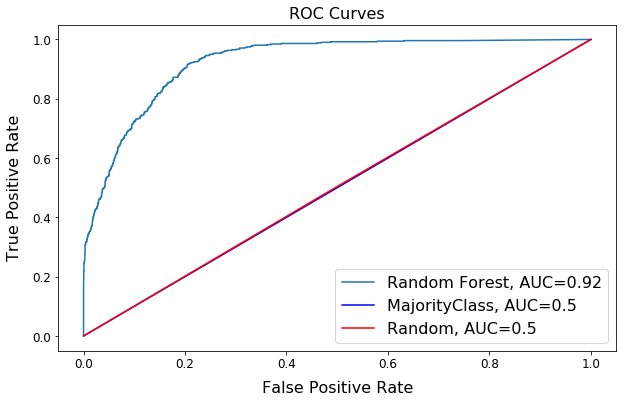

In [14]:
#284847138 Bank
build_model(dataset[284847138],app_names[284847138])

Building Models for  Realtorcom
Total features: 45
Training Shape: (15003, 45)
Testing Shape: (3751, 45)
====================FINDING CORRELATED FEATURES====================
Correlated features: NumBodyChars , UniqueWordsBody is 0.7095671516304285
Mutual Information for NumBodyChars is 0.04160089631472852 and for UniqueWordsBody is 0.030828143180048784
--------------------
Correlated features: NumTitleChars , UniqueWordsTitle is 0.8428569444659127
Mutual Information for NumTitleChars is 0.01664631642816672 and for UniqueWordsTitle is 0.011216423990476843
--------------------
Correlated features: VoteHelpful , VoteTotal is 0.9063207621393422
Mutual Information for VoteHelpful is 0.007773328282492997 and for VoteTotal is 0.0
--------------------
There are 3 columns to remove. which are ['UniqueWordsBody', 'UniqueWordsTitle', 'VoteTotal']
Selected features:
['Rating', 'PD_body', 'FR_body', 'IS_body', 'IG_body', 'NumBodyChars', 'NumTitleChars', 'BodySentiment', 'TitleSentiment', 'Readabilit

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed: 15.9min finished


Best CV parameters obtained are:  {'n_estimators': 900, 'min_samples_split': 0.01, 'min_samples_leaf': 3, 'max_features': 20, 'max_depth': 10, 'bootstrap': True}
====================Calculate AUC scores====================
Training AUC score: 0.8423054842295064
Testing AUC score: 0.8101967489391544
====================Feature Importance Analysis====================
Individual Feature Importance----
Variable: Rating               Importance: 0.163
Variable: NumBodyChars         Importance: 0.032
Variable: TimeAfterRelease     Importance: 0.02
Variable: PositiveWordsBody    Importance: 0.018
Variable: NegativeWordsBody    Importance: 0.01
Variable: NumTitleChars        Importance: 0.009
Variable: ModalVerbsBody       Importance: 0.008
Variable: FR_body              Importance: 0.007
Variable: PD_body              Importance: 0.005
Variable: PositiveWordsTitle   Importance: 0.005
Variable: NegativeWordsTitle   Importance: 0.005
Variable: ReadabilityBody      Importance: 0.002
Variable: Mi

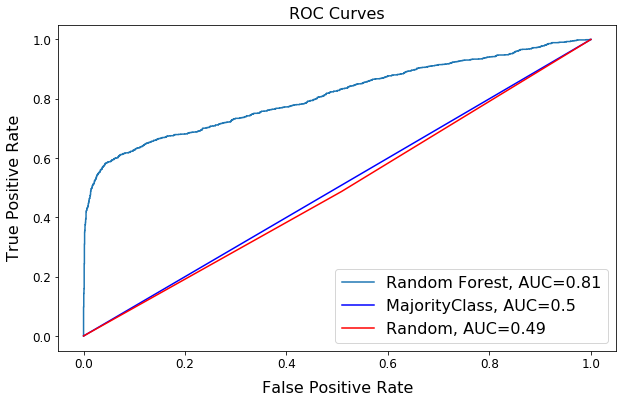

In [15]:
#336698281 Realtorcom
build_model(dataset[336698281],app_names[336698281])

Building Models for  Discord
Total features: 45
Training Shape: (6816, 45)
Testing Shape: (1705, 45)
====================FINDING CORRELATED FEATURES====================
Correlated features: NumBodyChars , UniqueWordsBody is 0.8035875873790843
Mutual Information for NumBodyChars is 0.005814437311681964 and for UniqueWordsBody is 0.0022930341143923005
--------------------
Correlated features: NumTitleChars , UniqueWordsTitle is 0.8779971036439954
Mutual Information for NumTitleChars is 0.016775693988597462 and for UniqueWordsTitle is 0.0
--------------------
Correlated features: VoteHelpful , VoteTotal is 0.7960710326123108
Mutual Information for VoteHelpful is 0.0 and for VoteTotal is 0.008073461287168238
--------------------
There are 3 columns to remove. which are ['UniqueWordsBody', 'UniqueWordsTitle', 'VoteHelpful']
Selected features:
['Rating', 'PD_body', 'FR_body', 'IS_body', 'IG_body', 'NumBodyChars', 'NumTitleChars', 'BodySentiment', 'TitleSentiment', 'ReadabilityBody', 'Misspel

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  9.4min finished


Best CV parameters obtained are:  {'n_estimators': 1000, 'min_samples_split': 0.01, 'min_samples_leaf': 1, 'max_features': 42, 'max_depth': 20, 'bootstrap': True}
====================Calculate AUC scores====================
Training AUC score: 0.9788883845268461
Testing AUC score: 0.9404584022038567
====================Feature Importance Analysis====================
Individual Feature Importance----
Variable: Rating               Importance: 0.35
Variable: NegativeWordsBody    Importance: 0.009
Variable: TimeAfterRelease     Importance: 0.009
Variable: PositiveWordsBody    Importance: 0.008
Variable: NumBodyChars         Importance: 0.007
Variable: PositiveWordsTitle   Importance: 0.007
Variable: MisspelledWordsBody  Importance: 0.005
Variable: IsWeekend            Importance: 0.005
Variable: PD_title             Importance: 0.004
Variable: NumTitleChars        Importance: 0.003
Variable: ModalVerbsBody       Importance: 0.003
Variable: PD_body              Importance: 0.002
Variable: 

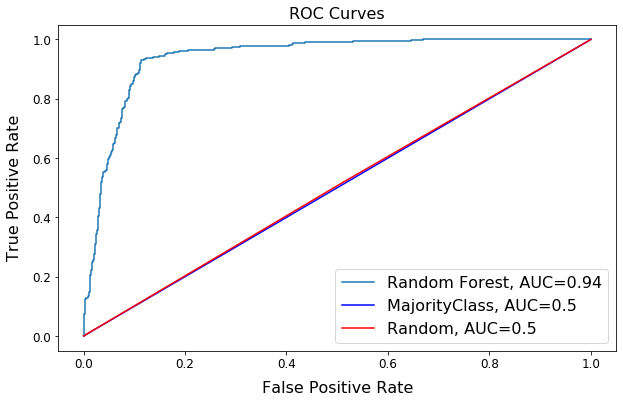

In [16]:
#985746746 Discord
build_model(dataset[985746746],app_names[985746746])

Building Models for  StockX
Total features: 45
Training Shape: (13184, 45)
Testing Shape: (3297, 45)
====================FINDING CORRELATED FEATURES====================
Correlated features: NumTitleChars , UniqueWordsTitle is 0.8392575839442419
Mutual Information for NumTitleChars is 0.004674900907068791 and for UniqueWordsTitle is 0.0029900354022309727
--------------------
Correlated features: FirstCapBody , FirstCapTitle is 0.7551239116241191
Mutual Information for FirstCapBody is 0.0 and for FirstCapTitle is 0.0023798618150838724
--------------------
Correlated features: VoteHelpful , VoteTotal is 0.9501175042768846
Mutual Information for VoteHelpful is 0.003026834772067888 and for VoteTotal is 0.0008335185545760293
--------------------
There are 3 columns to remove. which are ['UniqueWordsTitle', 'FirstCapBody', 'VoteTotal']
Selected features:
['Rating', 'PD_body', 'FR_body', 'IS_body', 'IG_body', 'NumBodyChars', 'NumTitleChars', 'BodySentiment', 'TitleSentiment', 'ReadabilityBody'

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed: 13.0min finished


Best CV parameters obtained are:  {'n_estimators': 400, 'min_samples_split': 0.01, 'min_samples_leaf': 3, 'max_features': 34, 'max_depth': 40, 'bootstrap': True}
====================Calculate AUC scores====================
Training AUC score: 0.8189031817020942
Testing AUC score: 0.6941063129797044
====================Feature Importance Analysis====================
Individual Feature Importance----
Variable: NumBodyChars         Importance: 0.162
Variable: TimeAfterRelease     Importance: 0.16
Variable: PositiveWordsBody    Importance: 0.023
Variable: IsWeekend            Importance: 0.021
Variable: NumTitleChars        Importance: 0.014
Variable: Is_Saturday          Importance: 0.014
Variable: UniqueWordsBody      Importance: 0.013
Variable: Is_Friday            Importance: 0.01
Variable: MisspelledWordsBody  Importance: 0.007
Variable: PositiveWordsTitle   Importance: 0.007
Variable: Rating               Importance: 0.006
Variable: NegativeWordsBody    Importance: 0.006
Variable: Is

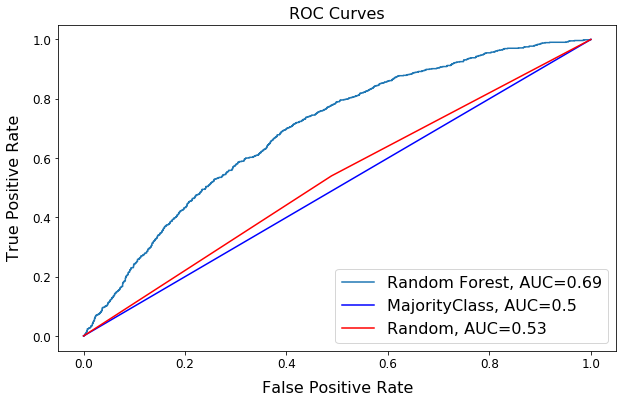

In [17]:
#881599819 StockX
build_model(dataset[881599819],app_names[881599819])

Building Models for  Reflectly
Total features: 45
Training Shape: (13541, 45)
Testing Shape: (3386, 45)
====================FINDING CORRELATED FEATURES====================
Correlated features: NumBodyChars , UniqueWordsBody is 0.8014708497195792
Mutual Information for NumBodyChars is 0.010235273692265512 and for UniqueWordsBody is 0.005703565655352794
--------------------
Correlated features: NumTitleChars , UniqueWordsTitle is 0.8525070466882196
Mutual Information for NumTitleChars is 0.0019495391758987957 and for UniqueWordsTitle is 0.0
--------------------
Correlated features: FirstCapBody , FirstCapTitle is 0.8105703600366642
Mutual Information for FirstCapBody is 0.0032280815077356806 and for FirstCapTitle is 0.0
--------------------
Correlated features: VoteHelpful , VoteTotal is 0.8605988193520804
Mutual Information for VoteHelpful is 0.0 and for VoteTotal is 0.002676018379542011
--------------------
There are 4 columns to remove. which are ['UniqueWordsBody', 'UniqueWordsTitle'

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed: 14.7min finished


Best CV parameters obtained are:  {'n_estimators': 700, 'min_samples_split': 0.01, 'min_samples_leaf': 1, 'max_features': 6, 'max_depth': 40, 'bootstrap': True}
====================Calculate AUC scores====================
Training AUC score: 0.9358243281957427
Testing AUC score: 0.7769647696476965
====================Feature Importance Analysis====================
Individual Feature Importance----
Variable: TimeAfterRelease     Importance: 0.154
Variable: Rating               Importance: 0.05
Variable: PositiveWordsBody    Importance: 0.038
Variable: Is_Tuesday           Importance: 0.03
Variable: NumBodyChars         Importance: 0.029
Variable: NumTitleChars        Importance: 0.021
Variable: NegativeWordsBody    Importance: 0.021
Variable: Is_Thursday          Importance: 0.021
Variable: ReadabilityBody      Importance: 0.017
Variable: PositiveWordsTitle   Importance: 0.016
Variable: MisspelledWordsBody  Importance: 0.013
Variable: Is_Wednesday         Importance: 0.012
Variable: Mod

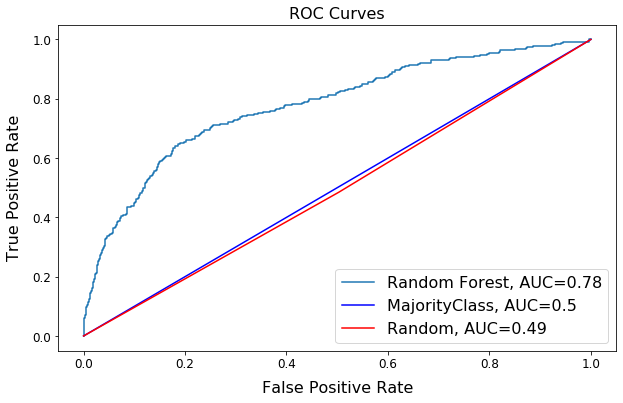

In [18]:
#1241229134 Reflectly
build_model(dataset[1241229134],app_names[1241229134])

Building Models for  WeatherBug
Total features: 45
Training Shape: (6402, 45)
Testing Shape: (1601, 45)
====================FINDING CORRELATED FEATURES====================
Correlated features: NumBodyChars , UniqueWordsBody is 0.7722138657757801
Mutual Information for NumBodyChars is 0.0028069087798039405 and for UniqueWordsBody is 0.013566960839614284
--------------------
Correlated features: NumTitleChars , UniqueWordsTitle is 0.8327484312966023
Mutual Information for NumTitleChars is 0.016020379391121775 and for UniqueWordsTitle is 0.0035838363064066847
--------------------
Correlated features: VoteHelpful , VoteTotal is 0.9324876765616545
Mutual Information for VoteHelpful is 0.0 and for VoteTotal is 0.0
--------------------
There are 3 columns to remove. which are ['NumBodyChars', 'UniqueWordsTitle', 'VoteTotal']
Selected features:
['Rating', 'PD_body', 'FR_body', 'IS_body', 'IG_body', 'NumTitleChars', 'BodySentiment', 'TitleSentiment', 'ReadabilityBody', 'MisspelledWordsBody', 'M

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  8.0min finished


Best CV parameters obtained are:  {'n_estimators': 600, 'min_samples_split': 0.01, 'min_samples_leaf': 3, 'max_features': 34, 'max_depth': 90, 'bootstrap': True}
====================Calculate AUC scores====================
Training AUC score: 0.998504473626527
Testing AUC score: 0.9902259562906837
====================Feature Importance Analysis====================
Individual Feature Importance----
Variable: Rating               Importance: 0.282
Variable: TimeAfterRelease     Importance: 0.007
Variable: Is_Thursday          Importance: 0.002
Variable: PositiveWordsBody    Importance: 0.001
Variable: PD_body              Importance: 0.0
Variable: FR_body              Importance: 0.0
Variable: IS_body              Importance: 0.0
Variable: IG_body              Importance: 0.0
Variable: NumTitleChars        Importance: 0.0
Variable: BodySentiment        Importance: 0.0
Variable: TitleSentiment       Importance: 0.0
Variable: ReadabilityBody      Importance: 0.0
Variable: MisspelledWordsBo

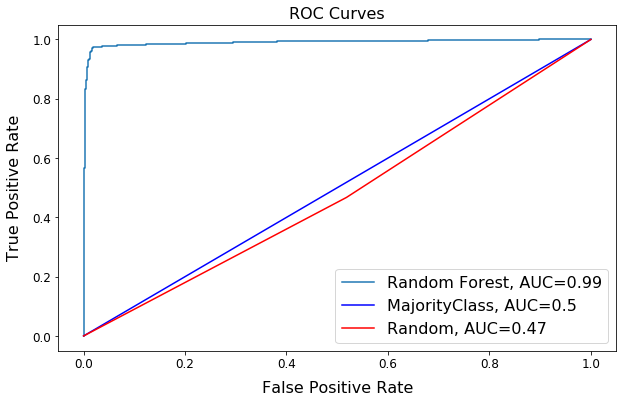

In [19]:
#281940292 WeatherBug
build_model(dataset[281940292],app_names[281940292])

Building Models for  PayPal
Total features: 45
Training Shape: (15616, 45)
Testing Shape: (3905, 45)
====================FINDING CORRELATED FEATURES====================
Correlated features: NumBodyChars , UniqueWordsBody is 0.8106333534006492
Mutual Information for NumBodyChars is 0.015627549790865114 and for UniqueWordsBody is 0.01429403511779559
--------------------
Correlated features: NumTitleChars , UniqueWordsTitle is 0.8642954261398104
Mutual Information for NumTitleChars is 0.003877886879331216 and for UniqueWordsTitle is 0.00151671656964103
--------------------
Correlated features: VoteHelpful , VoteTotal is 0.8753000408645737
Mutual Information for VoteHelpful is 0.00016719599624592796 and for VoteTotal is 0.001168157959313909
--------------------
There are 3 columns to remove. which are ['UniqueWordsBody', 'UniqueWordsTitle', 'VoteHelpful']
Selected features:
['Rating', 'PD_body', 'FR_body', 'IS_body', 'IG_body', 'NumBodyChars', 'NumTitleChars', 'BodySentiment', 'TitleSentim

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed: 15.8min finished


Best CV parameters obtained are:  {'n_estimators': 500, 'min_samples_split': 0.01, 'min_samples_leaf': 1, 'max_features': 34, 'max_depth': 20, 'bootstrap': True}
====================Calculate AUC scores====================
Training AUC score: 0.9094251479831102
Testing AUC score: 0.8493526279893517
====================Feature Importance Analysis====================
Individual Feature Importance----
Variable: Rating               Importance: 0.157
Variable: PositiveWordsBody    Importance: 0.048
Variable: TimeAfterRelease     Importance: 0.035
Variable: MisspelledWordsBody  Importance: 0.029
Variable: PD_body              Importance: 0.027
Variable: NumBodyChars         Importance: 0.025
Variable: NegativeWordsBody    Importance: 0.01
Variable: ModalVerbsBody       Importance: 0.009
Variable: NumTitleChars        Importance: 0.007
Variable: PositiveWordsTitle   Importance: 0.006
Variable: NegativeWordsTitle   Importance: 0.004
Variable: BodySentiment        Importance: 0.003
Variable: R

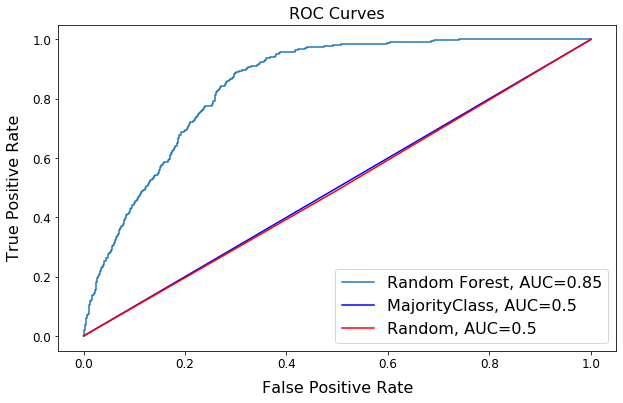

In [20]:
#283646709 PayPal
build_model(dataset[283646709],app_names[283646709])

In [21]:
len(roc_score_hist)

8

In [22]:
len(auc_score_app)

8

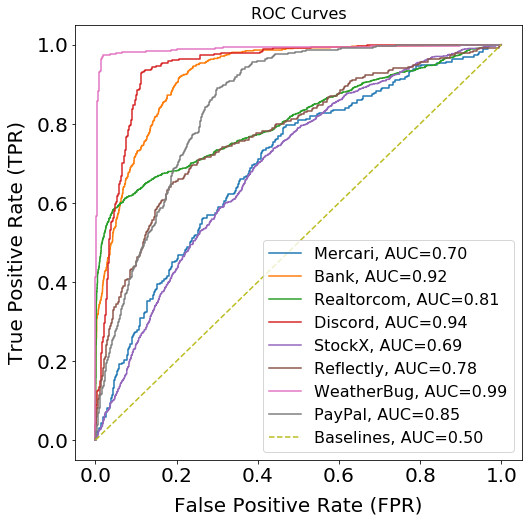

In [23]:
from sklearn import metrics
import random

np.random.seed(random_seed)
tmp = [random.randint(0,1) for x in range(100)]
plt.figure(figsize = (8, 8))
plt.rcParams['font.size'] = 20
for k,v in roc_score_hist.items():
    fpr = v["fpr"]
    tpr = v["tpr"]
    val = "%.2f" % round(auc_score_app[k], 2)
    plt.plot(fpr,tpr,label=k+", AUC="+str(val))
base_majority_fpr, base_majority_tpr, _ = metrics.roc_curve(tmp, [1 for _ in range(len(tmp))])
plt.plot(base_majority_fpr,base_majority_tpr,'--',label="Baselines, AUC=0.50")
plt.legend(loc=4,fontsize = 16)
plt.xlabel('False Positive Rate (FPR)',fontsize = 20,labelpad=10)
plt.ylabel('True Positive Rate (TPR)',fontsize = 20,labelpad=10)
plt.title('ROC Curves',fontsize = 16)
plt.savefig(result_dir+"/all_auc_baseline_curve.png",bbox_inches='tight')
plt.show()